In [1]:
import numpy as np

import torch
import torch.nn as nn

import jax.numpy as jnp

import matplotlib.pyplot as plt

In [4]:
def DDM(mu, sequence_length, sigma=0.5, dt=1, seed=None):
    if seed is not None:
        np.random.seed(seed) 
    num_trajectories = len(mu)
    num_steps = int(sequence_length / dt)
    x = np.zeros((num_trajectories, num_steps + 1))

    for i in range(num_trajectories):
        for t in range(num_steps):
            x[i, t + 1] = x[i, t] + mu[i] * dt + sigma * np.sqrt(dt) * np.random.normal()
    
    p = np.sign(mu)
    x = x[:, :, None]
    return torch.tensor(x, dtype=torch.float32), torch.tensor(p, dtype=torch.long)

def mse_loss(z, p):
    return ((z - p)**2).mean()
    
class DriftDiffusionRNN(torch.nn.Module):
    def __init__(self, hidden_size, input_size, output_size):
        super(DriftDiffusionRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = torch.nn.RNNCell(input_size, hidden_size, nonlinearity='tanh')
        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_i = torch.zeros(x.shape[0], self.hidden_size)
        z = torch.zeros(x.shape[0], 1)
        mask = torch.ones(x.shape[0], 1, dtype=torch.bool)  #array of True 
        ls_h_i = []
        for i in range(x.shape[1]):
            h_i = self.rnn(x[:, i], h_i)
            output = self.fc(h_i)
            z += output * mask 

            mask = torch.logical_and(mask, z.abs() < 1)    #False if threshold is reached

            ls_h_i.append(h_i)
            if mask.sum() == 0:
                break

        return z, ls_h_i

def train_model(model, optimizer, mu, iterations=10, sequence_length=50, save_path = 'model.pth'):
    model.train()
    ls_loss = []
    for iter in range(iterations):
        x, p = DDM(mu, sequence_length)
        optimizer.zero_grad()
        z, ls_h_i = model(x)  
        loss = mse_loss(z, p)
        loss.backward()
        optimizer.step()

        ls_loss.append(loss.item())
        print(f'Iteration [{iter+1}/{iterations}], Loss: {loss.item():.4f}')
    #torch.save(model.state_dict(), save_path)
    return ls_loss

mu = np.array([-0.64, -0.16, -0.04, 0.04, 0.16,0.64])  

lr=1e-3
model = DriftDiffusionRNN(hidden_size=100, input_size=1, output_size=1)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

sequence_length=50
ls_loss = train_model(model, optimizer, mu,  iterations=1000,  sequence_length=50)




Iteration [1/1000], Loss: 1.8403
Iteration [2/1000], Loss: 2.0977
Iteration [3/1000], Loss: 2.1154
Iteration [4/1000], Loss: 1.8924
Iteration [5/1000], Loss: 1.7459
Iteration [6/1000], Loss: 2.0722
Iteration [7/1000], Loss: 1.9669
Iteration [8/1000], Loss: 1.7213
Iteration [9/1000], Loss: 2.0732
Iteration [10/1000], Loss: 1.6487
Iteration [11/1000], Loss: 1.8943
Iteration [12/1000], Loss: 2.0803
Iteration [13/1000], Loss: 1.9728
Iteration [14/1000], Loss: 2.0205
Iteration [15/1000], Loss: 1.8835
Iteration [16/1000], Loss: 1.9019
Iteration [17/1000], Loss: 1.6087
Iteration [18/1000], Loss: 2.0787
Iteration [19/1000], Loss: 2.0924
Iteration [20/1000], Loss: 2.1334
Iteration [21/1000], Loss: 1.9181
Iteration [22/1000], Loss: 2.0392
Iteration [23/1000], Loss: 1.7874
Iteration [24/1000], Loss: 1.8541
Iteration [25/1000], Loss: 1.8992
Iteration [26/1000], Loss: 1.8396
Iteration [27/1000], Loss: 1.8106
Iteration [28/1000], Loss: 1.2522
Iteration [29/1000], Loss: 1.8024
Iteration [30/1000], Lo

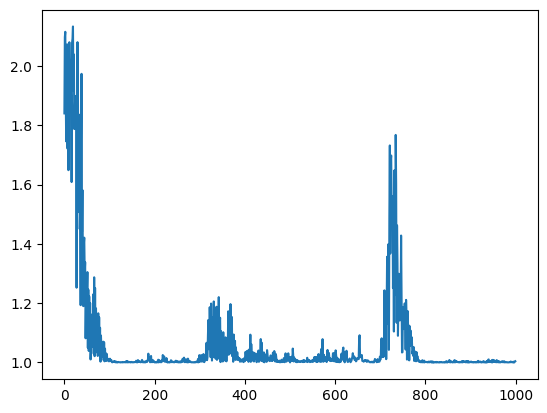

In [7]:
plt.plot(ls_loss)

In [8]:
x, p = DDM(mu, sequence_length=50)
z, ls_h_i = model(x)

ls_X = [jnp.array(tensor.detach().numpy()) for tensor in ls_h_i]
X = jnp.stack(ls_X, axis=1).swapaxes(1,2) 